<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idősorok előrebecslése mély tanulással

Mottó: a jóslás nehéz műfaj, főleg a jövőre vonatkozó

## Adatok előkészítése

A KSH oldaláról letölthető, 2015 napjainkig tartó halálozási adatokat fogjuk használni. Az adatok heti bontásban és több korcsoportra állnak rendelkezésre. Mi csak a heti összesítést fogjuk használni, egyváltozós adatsorként.

Az adatokat egy pandas adatkeretbe töltjük be.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import zeros, mean, array
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, InputLayer, Input
from keras.models import Model

# adatok letöltése
!wget -q https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/machine_learning/lessons/data/weekly_death.csv
df = pd.read_csv('weekly_death.csv', parse_dates=['start', 'end'])
df[['start', 'end', 'all_total']].head()

,start,end,all_total
0,2014-12-29,2015-01-04,2800
1,2015-01-05,2015-01-11,3005
2,2015-01-12,2015-01-18,2900
3,2015-01-19,2015-01-25,3005
4,2015-01-26,2015-02-01,3067


Nézzük meg az adatok időbeli változásátt!

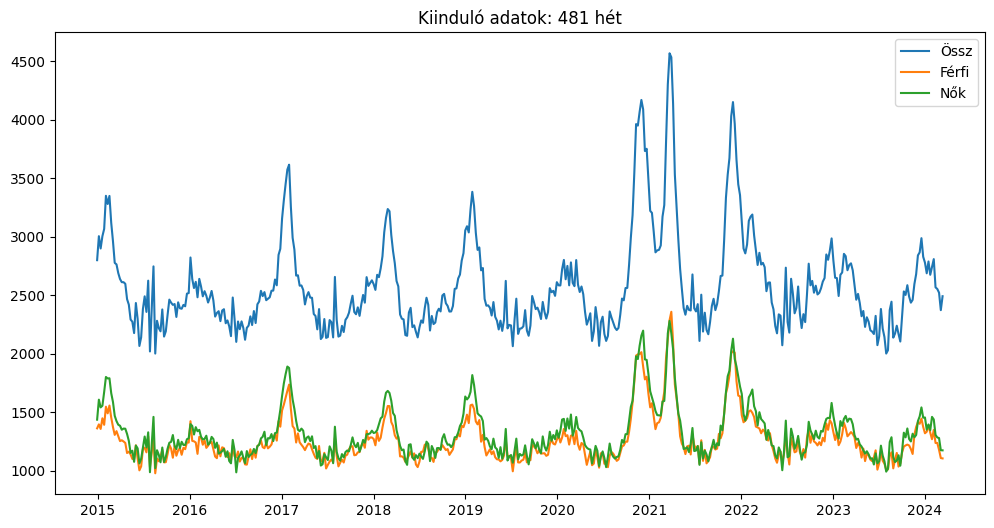

In [3]:
plt.figure(figsize=(12,6))
plt.plot(df['start'], df['all_total'], label='Össz')
plt.plot(df['start'], df['man_total'], label='Férfi')
plt.plot(df['start'], df['woman_total'], label='Nők')
plt.legend()
_ = plt.title(f'Kiinduló adatok: {df.shape[0]} hét')

Kialakítjuk a rövid, *n_steps* hosszúságú adatsorokat a modellek tanításához. Próbálja ki nagyobb hosszúságú adatsorokkal is a modelleket.

In [4]:
def split_sequence(seq, n_steps):
    """ change unvariate time serie into n_steps samples
        seq: univaiate time serie (a pandas serie, list)
        n_steps: length of samples
        returns: X, y (numpy arrays)
    """
    sequence = seq.to_numpy()
    n = sequence.shape[0]
    X = zeros((n - n_steps, n_steps))
    y = sequence[n_steps:]
    X = np.array([sequence[i:i+n_steps] for i in range(0, n-n_steps)])
    #for i in range(n-n_steps):
    #	X[i] = sequence[i:i+n_steps]
    return X, y

In [5]:
def prepare(seq, n_steps, n_features, test_rate=0.1):
    """ prepare univariate data and split into train and test parts
        seq: univaiate time serie (a pandas serie, list)
        n_steps: length of samples
        test_rate: rate of test data
        returns X_train, y_train, X_test, y_test
    """
    # split into samples
    X, y = split_sequence(seq, n_steps)
    #n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # split train and test data
    n_test = int(test_rate * y.shape[0])
    X_train = X[:-n_test]
    y_train = y[:-n_test]
    X_test = X[-n_test:]
    y_test = y[-n_test:]
    return X_train, y_train, X_test, y_test

In [17]:
# define input sequence
raw_seq = df['all_total']
# choose a number of time steps
n_steps = 3
EPOCHS = 1000
n_features = 1
test_rate = 0.05
X_train, y_train, X_test, y_test = prepare(raw_seq, n_steps, n_features, test_rate)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((455, 3, 1), (455,), (23, 3, 1), (23,))

## 1D konvolúciós neurális hálózat

Egy autoregresszív módszert használunk az adatok rövidtávú előrebecsléséhez.

In [18]:
# modell definíció
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
print(model.summary())
# modell tanítása
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                3250      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3493 (13.64 KB)
Trainable params: 3493 (13.64 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

Hasonlítsuk össze az ismert értékeket a modellből becsült adatokkal.

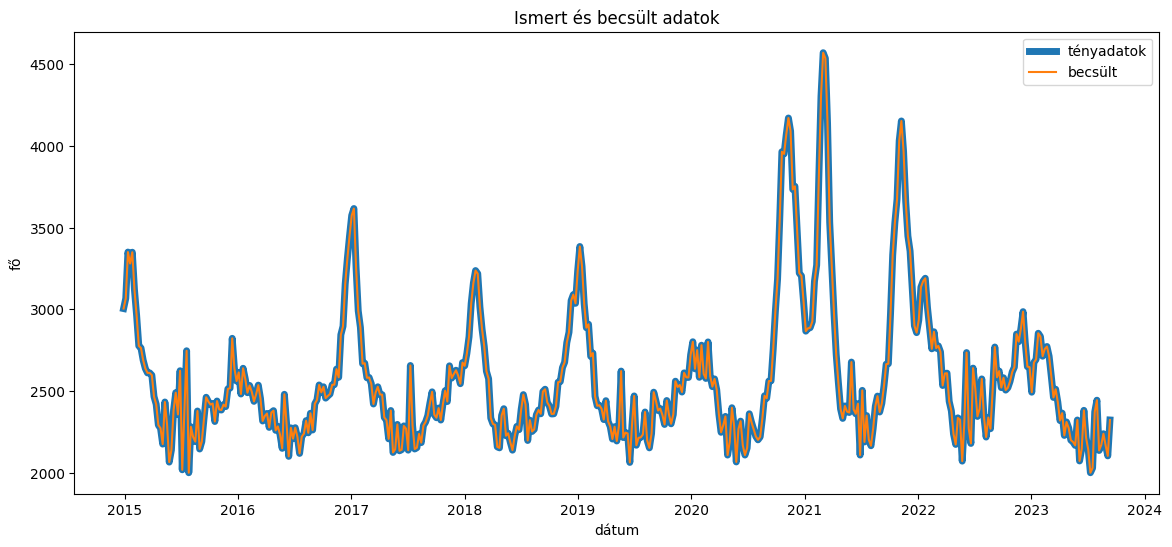

In [19]:
# predict values from model
train_size = y_train.shape[0]
y_pred = model.predict(X_train, verbose=0)
plt.figure(figsize=(14,6))
plt.xlabel("dátum")
plt.ylabel("fő")
plt.plot(df["start"][:train_size], y_train, linewidth=5.0, label='tényadatok')
plt.plot(df["start"][:train_size], y_train, label='becsült')   # TODO one week shift!
plt.legend()
_ = plt.title('Ismert és becsült adatok')

Becslés a teszt adatokra.

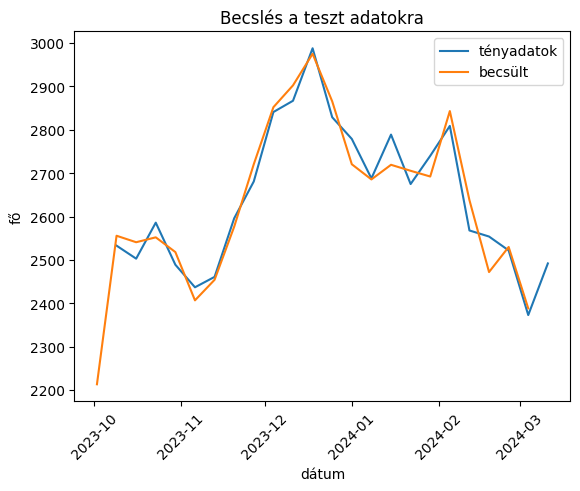

In [20]:
# make estimation for 2024 data
y_test_pred = model.predict(X_test, verbose=0)
test_size = y_test.shape[0]
offset = int(n_steps / 2)
plt.xlabel("dátum")
plt.ylabel("fő")
plt.plot(df['start'][-y_test.shape[0]:], y_test, label='tényadatok')
plt.plot(df['start'][-y_test.shape[0]-offset:-offset], y_test_pred[-y_test.shape[0]:], label='becsült')
plt.xticks(rotation=45)
plt.legend()
_ = plt.title('Becslés a teszt adatokra')

Néhány statisztikai adat a modell becsléséről.

In [21]:
# mean absolute percentage error MAPE
print(f"MAPE train: {mean_absolute_percentage_error(y_train, y_pred):5.1%}")
print(f"MAPE  test: {mean_absolute_percentage_error(y_test, y_test_pred):5.1%}")
# root mean square error
print(f"RMS  train: {mean_squared_error(y_train, y_pred)**0.5:.1f}")
print(f"RMS   test: {mean_squared_error(y_test, y_test_pred)**0.5:.1f}")

MAPE train:  4.7%
MAPE  test:  3.8%
RMS  train: 163.9
RMS   test: 123.6


Becsüljük egy következő értéket.

In [22]:
X_new = X_test[-1]
X_new = X_new.reshape(1, n_steps, 1)
y_new_pred = model.predict(X_new, verbose=0)
print(f"Becslés 2024.03.18-25 hétre: {int(y_new_pred[0, 0])}")

Becslés 2024.03.18-25 hétre: 2388


## Recurrent Neural Network (RNN)

Az RNN Long Short-Term Memory (LSTM) típusú neurális hálózatot használ.

In [23]:
inputs = Input(shape=(n_steps, n_features))
lstm = LSTM(50, activation="relu")(inputs)
outputs = Dense(1)(lstm)

lstm_model = Model(inputs, outputs)
lstm_model.compile(optimizer='adam', loss='mse')
print(lstm_model.summary())

lstm_hist =lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, verbose=0)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


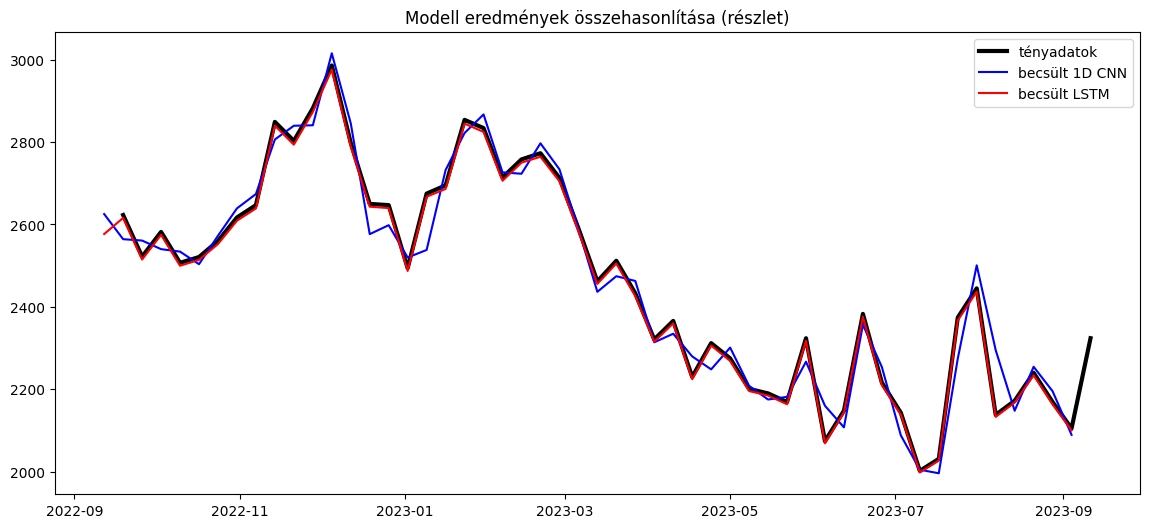

In [24]:
# predict values from model
y_lstm_pred = lstm_model.predict(X_train, verbose=0)
plt.figure(figsize=(14,6))
plt.plot(df["start"][train_size-52:train_size], y_train[-52:], c='black', linewidth=3.0, label='tényadatok')
plt.plot(df["start"][train_size-52-offset:train_size-offset], y_pred[-52:], c='blue', label='becsült 1D CNN')
plt.plot(df["start"][train_size-52-offset:train_size-offset], y_lstm_pred[-52:], c='red', label='becsült LSTM')
plt.legend()
_ = plt.title('Modell eredmények összehasonlítása (részlet)')

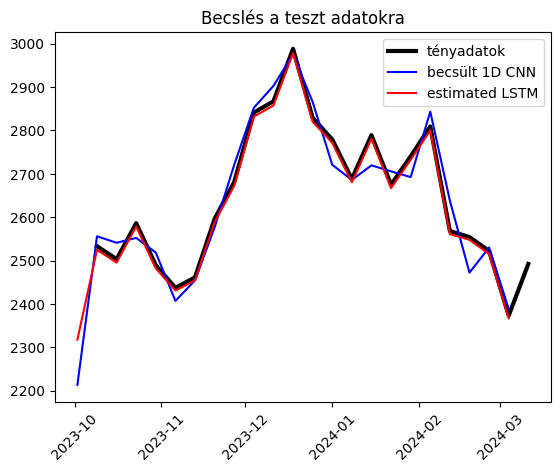

In [25]:
y_lstm_test_pred = lstm_model.predict(X_test, verbose=0)
plt.plot(df['start'][-test_size:], y_test, c='black', linewidth=3.0, label='tényadatok')
plt.plot(df['start'][-test_size-offset:-offset], y_test_pred, c='blue', label='becsült 1D CNN')
plt.plot(df['start'][-test_size-offset:-offset], y_lstm_test_pred, c='red', label='estimated LSTM')
plt.xticks(rotation=45)
plt.legend()
_ = plt.title('Becslés a teszt adatokra')

In [26]:
print("            CNN      RNN")
print(f"MAPE train: {mean_absolute_percentage_error(y_train, y_pred):6.1%}", end="")
print(f"    {mean_absolute_percentage_error(y_train, y_lstm_pred):6.1%}")
print(f"MAPE  test: {mean_absolute_percentage_error(y_test, y_test_pred):6.1%}", end="")
print(f"    {mean_absolute_percentage_error(y_test, y_lstm_test_pred):6.1%}")
# root mean square error
print(f"RMS  train: {mean_squared_error(y_train, y_pred)**0.5:5.1f}", end="")
print(f"     {mean_squared_error(y_train, y_lstm_pred)**0.5:5.1f}")
print(f"RMS   test: {mean_squared_error(y_test, y_test_pred)**0.5:5.1f}", end="")
print(f"     {mean_squared_error(y_test, y_lstm_test_pred)**0.5:5.1f}")

            CNN      RNN
MAPE train:   4.7%      4.6%
MAPE  test:   3.8%      3.7%
RMS  train: 163.9     161.6
RMS   test: 123.6     113.6


In [27]:
# predict for future
X_new_cnn = X_test[-1]
X_new_rnn = X_test[-1]
n_future = 5
print(f"Becslés CNN  RNN")
for i in range(n_future):
    y_new_cnn = model.predict(X_new_cnn.reshape(1, n_steps, n_features), verbose=0)
    y_new_rnn = lstm_model.predict(X_new_rnn.reshape(1, n_steps, n_features), verbose=0)
    print(f"{i+1:3}    {int(y_new_cnn[0, 0])} {int(y_new_rnn[0, 0])}")
    X_new_cnn = np.roll(X_new_cnn, -1)
    X_new_cnn[-1] = y_new_cnn[0, 0]
    X_new_rnn = np.roll(X_new_rnn, -1)
    X_new_rnn[-1] = y_new_rnn[0, 0]


Becslés CNN  RNN
  1    2388 2366
  2    2344 2360
  3    2368 2353
  4    2362 2346
  5    2383 2339
